In [1]:
import jsonlines
import numpy as np
import pandas as pd
from scipy import stats
from collections import defaultdict

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(1)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

In [2]:
# meta data

name_sets = {1: ['Top', 'Male', '2000s', 'White'],
             2: ['Top', 'Female', '2000s', 'White'],
             3: ['Medium', 'Male', '2000s', 'White'],
             4: ['Medium', 'Female', '2000s', 'White'],
             5: ['Bottom', 'Male', '2000s', 'White'],
             6: ['Bottom', 'Female', '2000s', 'White'],
             7: ['Medium', 'Male', '2000s', 'Black'],
             8: ['Medium', 'Female', '2000s', 'Black'],
             9: ['Medium', 'Male', '2000s', 'Asian'],
             10: ['Medium', 'Female', '2000s', 'Asian'],
             11: ['Medium', 'Male', '2000s', 'Hispanic'],
             12: ['Medium', 'Female', '2000s', 'Hispanic'],
             13: ['Top', 'Male', '1970s', 'White'],
             14: ['Top', 'Female', '1970s', 'White'],
             15: ['Top', 'Male', '1940s', 'White'],
             16: ['Top', 'Female', '1940s', 'White']}

dimensions = {'Gender': {'Male':[1,3,5,7,9,11,13,15], 'Female':[2,4,6,8,10,12,14,16]},
              'Race': {'White':[3,4], 'Black':[7,8], 'Asian':[9,10], 'Hispanic':[11,12]},
              'Popularity': {'Top':[1,2], 'Medium':[3,4], 'Bottom':[5,6]},
              'Decade': {'2000s':[1,2], '1970s':[13,14], '1940s':[15,16]}}

In [3]:
# load the labels

labels = defaultdict(dict)
with jsonlines.open('../Data/General/Input/notes-label.jsonl', 'r') as reader:
    for line in reader:
        ID, position, name = map(lambda x:tuple(x), line.values())
        labels[ID][position] = name

In [4]:
# load the predictions

preds = {}
models = ['spaCy', 'Stanza', 'flair', 'Amazon', 'Microsoft', 'Google', 'NeuroNER', 'Philter', 'MIST']
for model in models:
    preds[model] = defaultdict(dict)
    
    with jsonlines.open(f'../Data/General/Output/notes-{model}.jsonl', 'r') as reader:
        for line in reader:
            ID, position, name = map(lambda x:tuple(x), line.values())
            preds[model][ID][position] = name

### Polysemy Names

- List of Names with the Lowest Average Recall
- Models' Performance on the Three Polysemy Name Lists Different Races: Full Recall, Partial Recall (Can Models Recognize the Non-Polysemy Last Names?)

In [6]:
# calculate the recall of each sampled name

TP, FN = 'TP', 'FN'
name2count = defaultdict(int)
for ID, mentions in labels.items():
    for position, (name, _, group) in mentions.items():
        name2count[name] += 1

model2name2recall = defaultdict(dict)
model2name2count = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
for model in models:
    for ID, mentions in labels.items():
        for position, (name, _, set_) in mentions.items():
            if position in preds[model][ID] and name == preds[model][ID][position][0]:
                model2name2count[model][(name, set_)][TP] += 1
            else:
                model2name2count[model][(name, set_)][FN] += 1
    for (name, set_), count in model2name2count[model].items():
        tp, fn = model2name2count[model][(name, set_)][TP], model2name2count[model][(name, set_)][FN]
        model2name2recall[model][(name, set_)] = tp / (tp+fn)
        
ave_name2recall = defaultdict(int)
for model in models:
    for (name, set_), recall in model2name2recall[model].items():
        ave_name2recall[(name, set_)] += recall
for (name, set_) in ave_name2recall:
    ave_name2recall[(name, set_)] /= len(models)

In [7]:
# list of 10 names with the lowest average recall

for (name, set_), recall in sorted(ave_name2recall.items(), key=lambda x:x[1])[:10]:
    print(f'Set: {set_} | Name: {name} | Recall: {recall:.3f} | Number of occurrences: {name2count[name]}')

Set: 10 | Name: An Dizon | Recall: 0.296 | Number of occurrences: 12
Set: 10 | Name: An Son | Recall: 0.333 | Number of occurrences: 15
Set: 3 | Name: Wade Post | Recall: 0.333 | Number of occurrences: 25
Set: 9 | Name: Dat Yuen | Recall: 0.346 | Number of occurrences: 17
Set: 7 | Name: Cleveland Spikes | Recall: 0.349 | Number of occurrences: 7
Set: 3 | Name: Eldon Post | Recall: 0.389 | Number of occurrences: 12
Set: 4 | Name: Reba Post | Recall: 0.394 | Number of occurrences: 11
Set: 10 | Name: An Islam | Recall: 0.394 | Number of occurrences: 20
Set: 8 | Name: Ivory Pleasant | Recall: 0.398 | Number of occurrences: 29
Set: 4 | Name: Kala Post | Recall: 0.400 | Number of occurrences: 10


In [9]:
# load the labels and outputs for the polysemy test

poly_labels = defaultdict(dict)
with jsonlines.open('../Data/Polysemy/Input/polysemies-label.jsonl', 'r') as reader:
    for line in reader:
        ID, position, name = map(lambda x:tuple(x), line.values())
        poly_labels[ID][position] = name

poly_preds = {}
for model in models:
    poly_preds[model] = defaultdict(dict)
    with jsonlines.open(f'../Data/Polysemy/Output/polysemies-{model}.jsonl', 'r') as reader:
        for line in reader:
            ID, position, name = map(lambda x:tuple(x), line.values())
            poly_preds[model][ID][position] = name

In [16]:
# collect the raw data for completely/partially/not correct

set2model2full, set2model2partial = defaultdict(lambda: defaultdict(list)), defaultdict(lambda: defaultdict(list))
for ID, mentions in poly_labels.items():
    for position, (name, _, set_) in mentions.items():
        for model in models:
            if position in poly_preds[model][ID] and name == poly_preds[model][ID][position][0]:
                set2model2full[set_][model].append(1)
                set2model2partial[set_][model].append(1)
            else:
                set2model2full[set_][model].append(0)
                first, last = name.split(' ')
                last_position = (position[0]+len(first)+1, position[1])
                if last_position in poly_preds[model][ID] and last == poly_preds[model][ID][last_position][0]:
                    set2model2partial[set_][model].append(1)
                else:
                    set2model2partial[set_][model].append(0)

In [18]:
# calculate the ratio of completely/partially/not correct (completety correct = recall)

full2recall, full2yerr = np.zeros((len(models), len([3,7,11]))), np.zeros((len(models), 2, len([3,7,11])))
partial2recall, partial2yerr = np.zeros((len(models), len([3,7,11]))), np.zeros((len(models), 2, len([3,7,11])))

def boot(raw):
    recall = np.mean(raw)
    ci = stats.bootstrap((raw,), np.mean).confidence_interval
    return recall, recall-ci.low, ci.high-recall

for setID, set_ in enumerate([3,7,9]):
    for modelID, model in enumerate(models):
        
        recall, low, high = boot(set2model2full[set_][model])
        full2recall[modelID, setID] = recall
        full2yerr[modelID, :, setID] = (low, high)
        
        recall, low, high = boot(set2model2partial[set_][model])
        partial2recall[modelID, setID] = recall
        partial2yerr[modelID, :, setID] = (low, high)

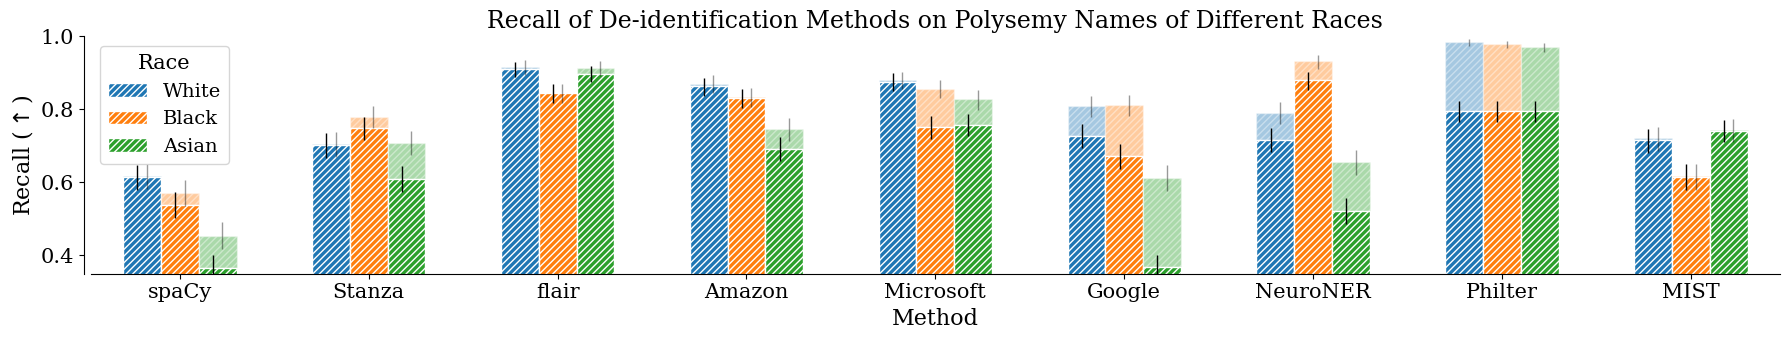

In [57]:
races = ['White', 'Black', 'Asian']

errorbar_offset = 0.025
fontsize = 16
colors = sns.color_palette('tab10', len(races))#; del colors[2]
width, middle = 0.6/len(races), np.arange(len(models))
fig, ax = plt.subplots(1,1, figsize=(2*len(models), 3.5*1))
sns.despine(ax=ax, offset=dict(left=5))

for groupID, group in enumerate(races):
    ax.bar(middle+width*(groupID-len(races)/2+0.5), bottom=full2recall[:,groupID], height=partial2recall[:,groupID]-full2recall[:,groupID], 
           width=width, color=colors[groupID], alpha=0.4, hatch='/////', edgecolor='white')
    ax.errorbar(middle+width*(groupID-len(races)/2+0.5)+errorbar_offset, partial2recall[:,groupID],
                yerr=partial2yerr[:,:,groupID].T, alpha=0.4, ecolor='black', elinewidth=1, fmt='none')
    ax.bar(middle+width*(groupID-len(races)/2+0.5), full2recall[:,groupID], 
           label=group, width=width, color=colors[groupID], hatch='/////', edgecolor='white')
    ax.errorbar(middle+width*(groupID-len(races)/2+0.5)-errorbar_offset, full2recall[:,groupID],
                yerr=full2yerr[:,:,groupID].T, ecolor='black', elinewidth=1, fmt='none')
    
ax.margins(x=0.02)
ax.set_ylim([0.35, 1])
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models)
ax.tick_params(axis='both', which='major', labelsize=fontsize-1)
ax.set_xlabel('Method', fontsize=fontsize)
ax.set_ylabel(r'Recall ($\uparrow$)', fontsize=fontsize)
ax.legend(loc=2, title='Race', title_fontsize=fontsize-1, fontsize=fontsize-2)
ax.set_title('Recall of De-identification Methods on Polysemy Names of Different Races', fontsize=fontsize+1)

plt.tight_layout()
plt.savefig('Figure/polysemy_recall.pdf')
plt.show()
plt.close(fig)

### Gender Context

- Models' Performance on Names in Agreement/Disagreement with the Gender Suggested by the Local Context

In [69]:
# calculate the recall of each model and each name set on names in agreement or disagreement with the gender suggested by the local context

letter2word = {'M':'Male', 'F':'Female'}
model2condition2raw = defaultdict(lambda: defaultdict(list))
model2diff, model2yerr = np.zeros(len(models)), np.zeros((len(models), 2))

for ID, mentions in labels.items():
    for position, (name, tag, set_) in mentions.items():
        if tag[8] == 'A': continue
        condition = set_ in dimensions['Gender'][letter2word[tag[8]]]
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]:
                model2condition2raw[model][condition].append(1)
            else:
                model2condition2raw[model][condition].append(0)
    
num_bootstrap = 9999
for modelID, model in enumerate(models):
    raw_agree, raw_disagree = np.array(model2condition2raw[model][True]), np.array(model2condition2raw[model][False])
    diff = raw_agree.mean() - raw_disagree.mean()
    
    indices = np.random.choice(len(raw_agree), (num_bootstrap, len(raw_agree)), replace=True)
    boot_agree, boot_disagree = raw_agree[indices], raw_disagree[indices]
    low, high = np.quantile(boot_agree.mean(-1) - boot_disagree.mean(-1), (0.025, 0.975))
    model2diff[modelID], model2yerr[modelID] = diff, (diff-low, high-diff)
    print(f'Model: {model} | Recall Diff: {diff:.3f} | Bootstrap CI: ({low:.3f}, {high:.3f})')

Model: spaCy | Recall Diff: -0.004 | Bootstrap CI: (-0.009, 0.001)
Model: Stanza | Recall Diff: 0.001 | Bootstrap CI: (-0.003, 0.005)
Model: flair | Recall Diff: 0.000 | Bootstrap CI: (-0.002, 0.002)
Model: Amazon | Recall Diff: 0.001 | Bootstrap CI: (-0.003, 0.004)
Model: Microsoft | Recall Diff: 0.002 | Bootstrap CI: (-0.001, 0.005)
Model: Google | Recall Diff: 0.004 | Bootstrap CI: (0.000, 0.007)
Model: NeuroNER | Recall Diff: 0.001 | Bootstrap CI: (-0.002, 0.004)
Model: Philter | Recall Diff: 0.000 | Bootstrap CI: (-0.003, 0.004)
Model: MIST | Recall Diff: 0.012 | Bootstrap CI: (0.007, 0.018)


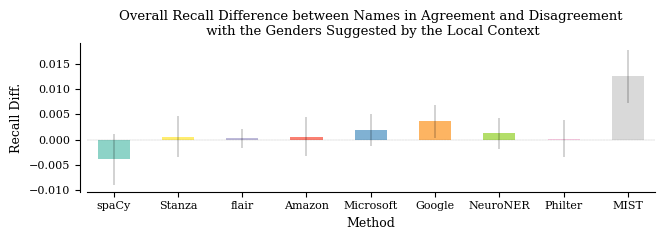

In [75]:
# draw the overall figure for (agree recall - disagree recall)

fontsize = 9
width, middle = 0.5, np.arange(len(models))
colors = np.array(sns.color_palette('Set3'))[[0,11,2,3,4,5,6,7,8]]
fig, ax = plt.subplots(1,1, figsize=(0.75*len(models), 2.5))
sns.despine(ax=ax, offset=dict(left=5))

ax.bar(middle, model2diff, width=width, color=colors,
       yerr=model2yerr.T, error_kw=dict(ecolor='black', elinewidth=0.25))
ax.axhline(0, linestyle='--', linewidth=0.1, color='k')
ax.margins(x=0.02)
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models)
ax.tick_params(axis='both', which='major', labelsize=fontsize-1)
ax.set_xlabel('Method', fontsize=fontsize)
ax.set_ylabel('Recall Diff.', fontsize=fontsize)
ax.set_title('Overall Recall Difference between Names in Agreement and Disagreement\n with the Genders Suggested by the Local Context', 
             fontsize=fontsize+0.5)
    
plt.tight_layout()
plt.savefig('Figure/context_difference.pdf')
plt.show()
plt.close(fig)

### Template Characteristics

- Any Template that is Particularly Hard to be De-identified? Ranking of the 100 Templates: Top 5 & Bottom 5
- Relationship between the Overall Recall on a Template and the Template Length & # Unique Names & # Name Mentions: overall
- \# Times in the Lowest/Highest 5 of Each Model: Characteristics

In [16]:
# calculate the average recall of names appearing in each template

model2template2raw = defaultdict(lambda: defaultdict(list))
for ID, mentions in labels.items():
    for position, (name, _, _) in mentions.items():
        for model in models[:ready]:
            if position in preds[model][ID] and name == preds[model][ID][position][0]:
                model2template2raw[model][ID[0]].append(1)
                model2template2raw['overall'][ID[0]].append(1)
            else:
                model2template2raw[model][ID[0]].append(0)
                model2template2raw['overall'][ID[0]].append(0)
                
recalls = []
model2recalls = defaultdict(list)
for templateID in range(100):
    recalls.append(np.mean(model2template2raw['overall'][templateID]))
    for model in models[:ready]:
        model2recalls[model].append(np.mean(model2template2raw[model][templateID]))

In [17]:
# collect the information of templates

pattern, length = '**NAME-', 11
def find_occurrences(template):
    occurrences = []
    index = template.find(pattern)
    while index != -1:
        occurrences.append((index, index+length, template[index:index+length]))
        index = template.find(pattern, index+length)
    return occurrences

lengths, uniques, mentions = [], [], []
templates = pd.read_csv('../Data/General/Input/notes-base.csv')
for _, row in templates.iterrows():
    occurrences = find_occurrences(row['text'])
    lengths.append(len(row['text']))
    uniques.append(len({name for _, _, name in occurrences}))
    mentions.append(len(occurrences))

In [18]:
# calculate the ranking of the 100 templates based on the average recall of names appearing in each template

ranking = np.argsort(recalls)
for category, templateIDs in zip(['Lowest 5', 'Highest 5'], [ranking[:5], ranking[-5:][::-1]]):
    print()
    print(category)
    for templateID in templateIDs:
        print(f'Template {templateID} | Overall Recall {recalls[templateID]:.3f} | ' + 
              f'Length {lengths[templateID]} | # Unique Names {uniques[templateID]} | # Name Mentions {mentions[templateID]}')


Lowest 5
Template 86 | Overall Recall 0.630 | Length 21822 | # Unique Names 5 | # Name Mentions 13
Template 67 | Overall Recall 0.682 | Length 8339 | # Unique Names 3 | # Name Mentions 10
Template 22 | Overall Recall 0.731 | Length 12773 | # Unique Names 7 | # Name Mentions 9
Template 79 | Overall Recall 0.771 | Length 20085 | # Unique Names 5 | # Name Mentions 8
Template 44 | Overall Recall 0.777 | Length 21072 | # Unique Names 6 | # Name Mentions 19

Highest 5
Template 50 | Overall Recall 0.952 | Length 3956 | # Unique Names 4 | # Name Mentions 8
Template 17 | Overall Recall 0.952 | Length 8128 | # Unique Names 2 | # Name Mentions 6
Template 92 | Overall Recall 0.946 | Length 7540 | # Unique Names 2 | # Name Mentions 5
Template 8 | Overall Recall 0.944 | Length 16104 | # Unique Names 4 | # Name Mentions 12
Template 80 | Overall Recall 0.942 | Length 5843 | # Unique Names 2 | # Name Mentions 4


In [22]:
# calculate the number of times a template appears in the lowest/highest 10 templates of a model by average recall

size = 5
category2template2count = defaultdict(lambda: defaultdict(int))
for model in models[:ready]:
    for templateID in model2rankings[model][:size]:
        category2template2count['lowest'][templateID] += 1
    for templateID in model2rankings[model][-size:]:
        category2template2count['highest'][templateID] += 1
        
category2count = {}
for category, template2count in category2template2count.items():
    print()
    print(f'Category: {category} {size} by {ready} models')
    for templateID, count in sorted(template2count.items(), key=lambda x:x[1], reverse=True):
        if count <= 1: continue
        print(f'{count} times: Template {templateID} | Overall Recall {recalls[templateID]:.3f} | ' + 
              f'Length {lengths[templateID]} | # Unique Names {uniques[templateID]} | # Name Mentions {mentions[templateID]}')


Category: lowest 5 by 9 models
6 times: Template 86 | Overall Recall 0.630 | Length 21822 | # Unique Names 5 | # Name Mentions 13
4 times: Template 67 | Overall Recall 0.682 | Length 8339 | # Unique Names 3 | # Name Mentions 10
3 times: Template 22 | Overall Recall 0.731 | Length 12773 | # Unique Names 7 | # Name Mentions 9
3 times: Template 19 | Overall Recall 0.791 | Length 10445 | # Unique Names 3 | # Name Mentions 5
2 times: Template 51 | Overall Recall 0.807 | Length 9391 | # Unique Names 3 | # Name Mentions 3
2 times: Template 55 | Overall Recall 0.811 | Length 24836 | # Unique Names 4 | # Name Mentions 10
2 times: Template 48 | Overall Recall 0.806 | Length 12074 | # Unique Names 2 | # Name Mentions 3
2 times: Template 33 | Overall Recall 0.816 | Length 14922 | # Unique Names 2 | # Name Mentions 4
2 times: Template 70 | Overall Recall 0.796 | Length 12815 | # Unique Names 3 | # Name Mentions 5
2 times: Template 44 | Overall Recall 0.777 | Length 21072 | # Unique Names 6 | # Nam

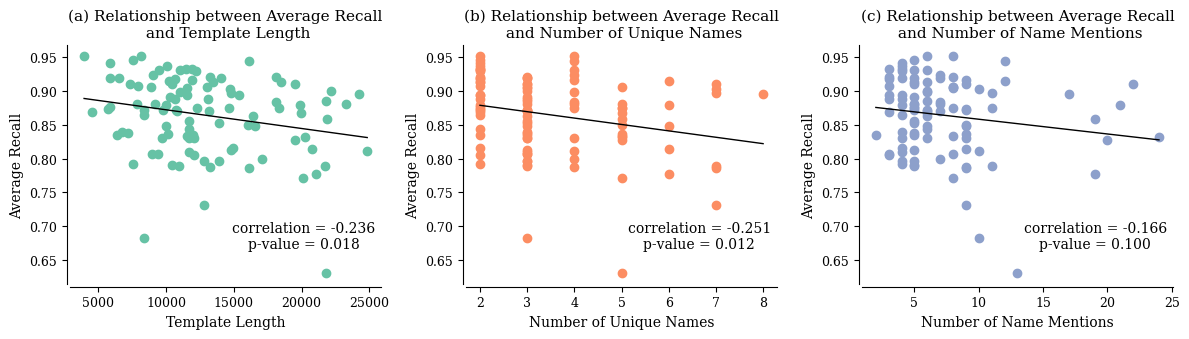

In [20]:
# draw the figure of the overall recall on a template against the template length & # unique names & # name mentions

def draw(axID, xlabel, x, y):
    
    ax = axs[axID]
    sns.despine(ax=ax, offset=dict(left=2, bottom=2))
    ax.scatter(x, y, color=colors[axID], marker='o')
    
    slope, intercept, r, p, _ = stats.linregress(x, y)
    ax.plot(np.unique(x), np.poly1d([slope, intercept])(np.unique(x)), color='k', lw=1)
    ax.text(0.75, 0.2, f'correlation = {r:.3f}\np-value = {p:.3f}', ha='center', va='center', fontsize=fontsize, transform=ax.transAxes)

    ax.tick_params(axis='both', which='major', labelsize=fontsize-1)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel('Average Recall', fontsize=fontsize)
    ax.set_title('({}) Relationship between Average Recall\n and {}'.format(chr(ord('a')+axID), xlabel), fontsize=fontsize+1)

fontsize = 10
colors = sns.color_palette('Set2', 3)
fig, axs = plt.subplots(1,3, figsize=(4*3, 3.5*1))
for axID, (xlabel, x) in enumerate(zip(['Template Length', 'Number of Unique Names', 'Number of Name Mentions'], [lengths, uniques, mentions])):
    draw(axID, xlabel, x, recalls)

plt.tight_layout()
plt.savefig('Figure/relationship_template.pdf')
plt.show()
plt.close(fig)